<a href="https://colab.research.google.com/github/aleshark87/data-intensive-project/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Descrizione del problema

*In questo progetto si vuole realizzare un modello in grado di predire la potabilità dell'acqua in base a delle analisi effettuate*

## Importo le librerie necessarie

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from urllib.request import urlretrieve

##Caricamento dei dati


In [3]:
dataset_url = "https://github.com/aleshark87/data-intensive-project/raw/main/water_potability%20(2).csv"
dataset_filename = "water_potability.csv"

if not os.path.exists(dataset_filename):
  urlretrieve(dataset_url, dataset_filename)

dataset = pd.read_csv(dataset_filename, sep=",")
dataset.head(10)  

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


##Comprensione delle feature


###Unità di misura:


*  **NTU**: Nephelometric Turbidity unit
*  **ppm**: Parti per milione
*  **μg/L**: Microgrammi per litro
*  **mg/L**: Milligrammi per litro

###Descrizione:

1. **ph**: Misura del pH dell'acqua.
2. **Hardness**: Misura della durezza dell'acqua. Viene espressa in mg/L.
3. **Solids**: Misura dei materiali disciolti. Viene espressa in ppm.
4. **Chloramines**: Misura delle clorammine in ppm.
5. **Sulfate**: Misura dei solfati in mg/L.
6. **Conductivity**: Conduttività elettrica dell'acqua in μS/cm.
7. **Organic_carbon**: Carbonio organico in ppm.
8. **Trihalomethanes**: Misura dei trialometani in μg/L.
9. **Turbidity**: Misura della torbidità in NTU.
10. **Potability**: Indica se l'acqua è potabile, 1 significa potabile e 0 significa non potabile.



##Esplorazione delle feature

In [4]:
dataset.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


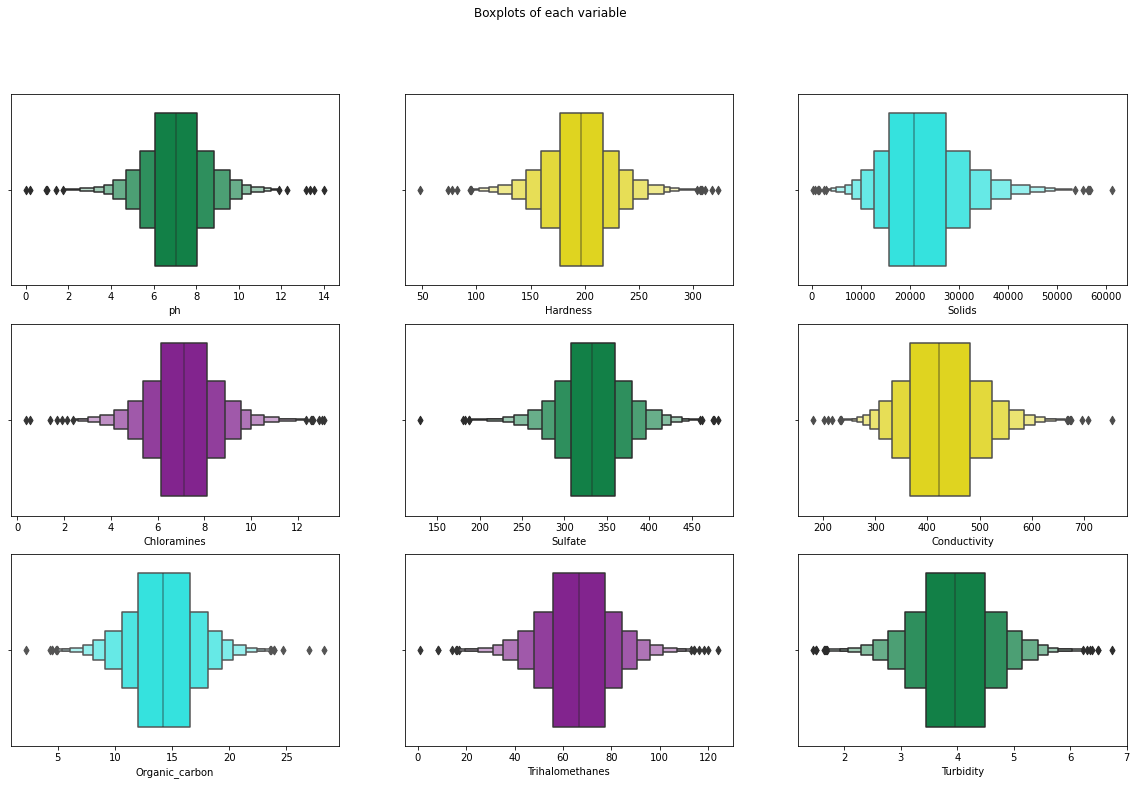

In [64]:
colors = ['#009246','#fff000','#18fff9','#8f139f']
fig, axes = plt.subplots(3, 3,figsize=(20,12))
column = dataset.columns
fig.suptitle('Boxplots of each variable')
sns.boxenplot(ax=axes[0,0],x=column[0],data=dataset,color=colors[0])
sns.boxenplot(ax=axes[0,1],x=column[1],data=dataset,color=colors[1])
sns.boxenplot(ax=axes[0,2],x=column[2],data=dataset,color=colors[2])
sns.boxenplot(ax=axes[1,0],x=column[3],data=dataset,color=colors[3])
sns.boxenplot(ax=axes[1,1],x=column[4],data=dataset,color=colors[0])
sns.boxenplot(ax=axes[1,2],x=column[5],data=dataset,color=colors[1])
sns.boxenplot(ax=axes[2,0],x=column[6],data=dataset,color=colors[2])
sns.boxenplot(ax=axes[2,1],x=column[7],data=dataset,color=colors[3])
sns.boxenplot(ax=axes[2,2],x=column[8],data=dataset,color=colors[0])
plt.show()

Il dataset ha alcuni valori null, vediamo quanti sono.

In [12]:
dataset.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Possiamo rimpiazzare i valori null di ph e trihalomethanes con la media, in quanto sono equamente distributi. Nel caso dei sulfate ho deciso di utilizzare la mediana, in quanto sono più sbilanciati. 

In [69]:
dataset['ph'].fillna(dataset['ph'].mean(),inplace=True)
dataset['Sulfate'].fillna(dataset['Sulfate'].median(),inplace=True)
dataset['Trihalomethanes'].fillna(dataset['Trihalomethanes'].mean(),inplace=True)
dataset.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64